# Kaggle Bag of Popcorn challenge
>In this tutorial competition, we dig a little "deeper" into sentiment analysis. Google's Word2Vec is a deep-learning inspired method that focuses on the meaning of words. Word2Vec attempts to understand meaning and semantic relationships among words. It works in a way that is similar to deep approaches, such as recurrent neural nets or deep neural nets, but is computationally more efficient. This tutorial focuses on Word2Vec for sentiment analysis.
>
>Sentiment analysis is a challenging subject in machine learning. People express their emotions in language that is often obscured by sarcasm, ambiguity, and plays on words, all of which could be very misleading for both humans and computers. There's another Kaggle competition for movie review sentiment analysis. In this tutorial we explore how Word2Vec can be applied to a similar problem.
>
>Deep learning has been in the news a lot over the past few years, even making it to the front page of the New York Times. These machine learning techniques, inspired by the architecture of the human brain and made possible by recent advances in computing power, have been making waves via breakthrough results in image recognition, speech processing, and natural language tasks. Recently, deep learning approaches won several Kaggle competitions, including a drug discovery task, and cat and dog image recognition.
>
>__Tutorial Overview__
>
>This tutorial will help you get started with Word2Vec for natural language processing. It has two goals: 
>
>Basic Natural Language Processing: Part 1 of this tutorial is intended for beginners and covers basic natural language processing techniques, which are needed for later parts of the tutorial.
>
>Deep Learning for Text Understanding: In Parts 2 and 3, we delve into how to train a model using Word2Vec and how to use the resulting word vectors for sentiment analysis.
>
>Since deep learning is a rapidly evolving field, large amounts of the work has not yet been published, or exists only as academic papers. Part 3 of the tutorial is more exploratory than prescriptive -- we experiment with several ways of using Word2Vec rather than giving you a recipe for using the output.
>
>To achieve these goals, we rely on an IMDB sentiment analysis data set, which has 100,000 multi-paragraph movie reviews, both positive and negative. 

In this notebook, I will explore the Word2Vec approaches.  I have already touched on BOW and TFIDF approaches in a previous notebook.  In the next notebook, I will delve into deep learning approaches

## 1. Load the Data

In [1]:
# Load the Data
import pandas as pd

train = pd.read_csv('labeledTrainData.tsv', header=0, delimiter='\t', quoting=3)
unlabeled_train = pd.read_csv('unlabeledTrainData.tsv', header=0, delimiter='\t', quoting=3)
test = pd.read_csv('testData.tsv', header=0, delimiter='\t', quoting=3)

print("Read %d labeled train reviews, %d labeled test reviews, " \
    "and %d unlabeled reviews\n" % (train["review"].size,  
    test["review"].size, unlabeled_train["review"].size))

Read 25000 labeled train reviews, 25000 labeled test reviews, and 50000 unlabeled reviews



In [2]:
train

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."
...,...,...,...
24995,"""3453_3""",0,"""It seems like more consideration has gone int..."
24996,"""5064_1""",0,"""I don't believe they made this film. Complete..."
24997,"""10905_3""",0,"""Guy is a loser. Can't get girls, needs to bui..."
24998,"""10194_3""",0,"""This 30 minute documentary Buñuel made in the..."


In [3]:
unlabeled_train

,id,review
0,"""9999_0""","""Watching Time Chasers, it obvious that it was..."
1,"""45057_0""","""I saw this film about 20 years ago and rememb..."
2,"""15561_0""","""Minor Spoilers<br /><br />In New York, Joan B..."
3,"""7161_0""","""I went to see this film with a great deal of ..."
4,"""43971_0""","""Yes, I agree with everyone on this site this ..."
...,...,...
49995,"""18984_0""","""The original Man Eater by Joe D'Amato is some..."
49996,"""16433_0""","""When Home Box Office was in it's early days m..."
49997,"""16006_0""","""Griffin Dunne was born into a cultural family..."
49998,"""40155_0""","""Not a bad story, but the low budget rears its..."


## 2. Text Preprocessing

Now, on to cleaning and preprocessing the data.

For Word2Vec, it is useful to keep stopwords since the algorithm relies on the broader context of the sentence in order to produce high quality word vectors. Also, not removing numbers since they may provide additional context. 

We also want to keep sentences separate unlike BOW approach where sentences didn't matter.  So here we'll use `WordPunctTokenizer` from `nltk` to split sentences apart b/c splitting sentences is pretty difficult. 

In [8]:
from bs4 import BeautifulSoup
import nltk
import re

# Create a function to clean the text
def review_to_wordlist(text, remove_stopwords=False):
    # strip html tags
    text = BeautifulSoup(text, "html.parser").get_text()
    
    # lower case, remove special characters, and strip leading and trailing whitespaces
    text = re.sub(r'[^a-zA-Z1-9]', ' ', text)
    
    # Create tokens
    words = text.lower().split()
    
    # filter out stopwords
    if remove_stopwords:
        stop_words = set(nltk.corpus.stopwords.words('english'))
        words = [word for word in words if word not in stop_words]

    return words

# Define a function to split a review into parsed sentences
pst = nltk.PunktSentenceTokenizer()
def review_to_sentences(review, remove_stopwords=False):
    raw_sentences = pst.tokenize(review.strip())
    
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(review_to_wordlist(raw_sentence, remove_stopwords))
    
    return sentences

Prepare data for input to Word2Vec

In [9]:
sentences = []

print("Parsing sentences from training set...")
for review in train['review']:
    sentences += review_to_sentences(review)

print("Parsing sentences from unlabeled training set...")
for review in unlabeled_train['review']:
    sentences += review_to_sentences(review)

Parsing sentences from training set...


C:\Users\aksin\Anaconda3\lib\site-packages\bs4\__init__.py:302: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Users\aksin\Anaconda3\lib\site-packages\bs4\__init__.py:302: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Users\aksin\Anaconda3\lib\site-packages\bs4\__init__.py:375: UserWarning: "http://www.happierabroad.com"" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


Parsing sentences from unlabeled training set...


C:\Users\aksin\Anaconda3\lib\site-packages\bs4\__init__.py:375: UserWarning: "http://www.archive.org/details/LovefromaStranger"" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\aksin\Anaconda3\lib\site-packages\bs4\__init__.py:375: UserWarning: "http://www.loosechangeguide.com/LooseChangeGuide.html"" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\aksin\Anaconda3\lib\site-packages\bs4\__init__.py:375: UserWarning: "http://www.msnbc.msn.com/id/4972055/site/newsweek/"" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the do

In [10]:
print(len(sentences))

801316


## 3. Split the data

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    train['review'], train['sentiment'], test_size=0.4, random_state=0)

In [12]:
print(X_train.shape, y_train.shape)

(15000,) (15000,)


In [13]:
print(X_test.shape, y_test.shape)

(10000,) (10000,)


## 4. Analyze Using Predictive Word Embeddings

Will use Gensim's Word2Vec implementation, GloVe and FastText. 

### 4.1 Word2Vec

The `gensim` frameword created by Radim Rehurek has a robust, efficient and scalable implementation of the Word2Vec Skip-Gram model.  That's what I'll be using here

#### 4.1.1 Train the Model

In [14]:
from gensim.models import word2vec
import logging 

# Configure logging so that Word2Vec creates nice output messages
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)

# Set parameter values
embed_size = 300 # Word vector dimensionality
window_context = 10 # Context window size
num_workers = 4 # Number of threads to run in parallel
min_word_count = 40 # Minimum word count
downsampling = 1e-3 # Downsample setting for frequent words

print("Training model...")
w2v_model = word2vec.Word2Vec(sentences, workers=num_workers, \
                              size=embed_size, window=window_context, 
                              min_count = min_word_count, sample=downsampling)

# Calling init_sims makes the model much more memory efficient if the model 
# is not expected to be trained any further
w2v_model.init_sims(replace=True)

# save the model for future use
model_name = "w2v_model_300features"
w2v_model.save(model_name)

2020-01-27 13:40:09,120 : INFO : collecting all words and their counts
2020-01-27 13:40:09,121 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-01-27 13:40:09,157 : INFO : PROGRESS: at sentence #10000, processed 226181 words, keeping 17912 word types
2020-01-27 13:40:09,198 : INFO : PROGRESS: at sentence #20000, processed 452687 words, keeping 25144 word types
2020-01-27 13:40:09,238 : INFO : PROGRESS: at sentence #30000, processed 671561 words, keeping 30272 word types
2020-01-27 13:40:09,279 : INFO : PROGRESS: at sentence #40000, processed 897947 words, keeping 34632 word types
2020-01-27 13:40:09,316 : INFO : PROGRESS: at sentence #50000, processed 1117306 words, keeping 38078 word types


Training model...


2020-01-27 13:40:09,358 : INFO : PROGRESS: at sentence #60000, processed 1338925 words, keeping 41078 word types
2020-01-27 13:40:09,399 : INFO : PROGRESS: at sentence #70000, processed 1561479 words, keeping 43680 word types
2020-01-27 13:40:09,440 : INFO : PROGRESS: at sentence #80000, processed 1780536 words, keeping 46129 word types
2020-01-27 13:40:09,480 : INFO : PROGRESS: at sentence #90000, processed 2005917 words, keeping 48518 word types
2020-01-27 13:40:09,519 : INFO : PROGRESS: at sentence #100000, processed 2227377 words, keeping 50653 word types
2020-01-27 13:40:09,556 : INFO : PROGRESS: at sentence #110000, processed 2447329 words, keeping 52506 word types
2020-01-27 13:40:09,595 : INFO : PROGRESS: at sentence #120000, processed 2668996 words, keeping 54576 word types
2020-01-27 13:40:09,632 : INFO : PROGRESS: at sentence #130000, processed 2893465 words, keeping 56326 word types
2020-01-27 13:40:09,668 : INFO : PROGRESS: at sentence #140000, processed 3107776 words, kee

2020-01-27 13:40:12,319 : INFO : PROGRESS: at sentence #780000, processed 17429296 words, keeping 123847 word types
2020-01-27 13:40:12,362 : INFO : PROGRESS: at sentence #790000, processed 17657555 words, keeping 124556 word types
2020-01-27 13:40:12,403 : INFO : PROGRESS: at sentence #800000, processed 17881718 words, keeping 125312 word types
2020-01-27 13:40:12,409 : INFO : collected 125408 word types from a corpus of 17910999 raw words and 801316 sentences
2020-01-27 13:40:12,409 : INFO : Loading a fresh vocabulary
2020-01-27 13:40:12,466 : INFO : effective_min_count=40 retains 16670 unique words (13% of original 125408, drops 108738)
2020-01-27 13:40:12,467 : INFO : effective_min_count=40 leaves 17347017 word corpus (96% of original 17910999, drops 563982)
2020-01-27 13:40:12,508 : INFO : deleting the raw counts dictionary of 125408 items
2020-01-27 13:40:12,511 : INFO : sample=0.001 downsamples 48 most-common words
2020-01-27 13:40:12,511 : INFO : downsampling leaves estimated 1

2020-01-27 13:41:01,433 : INFO : EPOCH 5 - PROGRESS: at 59.51% examples, 1270883 words/s, in_qsize 7, out_qsize 0
2020-01-27 13:41:02,433 : INFO : EPOCH 5 - PROGRESS: at 69.09% examples, 1265526 words/s, in_qsize 7, out_qsize 0
2020-01-27 13:41:03,436 : INFO : EPOCH 5 - PROGRESS: at 78.67% examples, 1261044 words/s, in_qsize 7, out_qsize 0
2020-01-27 13:41:04,437 : INFO : EPOCH 5 - PROGRESS: at 87.35% examples, 1245165 words/s, in_qsize 7, out_qsize 0
2020-01-27 13:41:05,447 : INFO : EPOCH 5 - PROGRESS: at 97.33% examples, 1247825 words/s, in_qsize 7, out_qsize 0
2020-01-27 13:41:05,716 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-27 13:41:05,719 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-27 13:41:05,722 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-27 13:41:05,726 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-27 13:41:05,726 : INFO : EPOCH - 5 : training on 17910999 

In [15]:
# view similar words based on gensim's model (just for curiosity's sake)
similar_words = {search_term: [item[0] for item in w2v_model.wv.most_similar([search_term], topn=5)]
                     for search_term in ['movie', 'sex', 'genre', 'scary', 'romance', 'action', 
                                         'indie', 'director', 'country', 'france', 'england', 
                                         'germany', 'man', 'woman', 'kitchen', 'city', 'berlin', 'paris']}
similar_words

{'movie': ['film', 'flick', 'it', 'movies', 'sequel'],
 'sex': ['sexual', 'masturbation', 'lesbian', 'nudity', 'rape'],
 'genre': ['thrillers', 'giallo', 'genres', 'conventions', 'category'],
 'scary': ['frightening', 'gory', 'funny', 'creepy', 'suspenseful'],
 'romance': ['romantic', 'drama', 'melodrama', 'rivalry', 'intrigue'],
 'action': ['suspense', 'excitement', 'thrills', 'explosions', 'shootouts'],
 'indie': ['independent', 'indy', 'exploitation', 'experimental', 'artsy'],
 'director': ['filmmaker',
  'directors',
  'cinematographer',
  'screenwriter',
  'producer'],
 'country': ['india', 'europe', 'nation', 'china', 'communities'],
 'france': ['italy', 'germany', 'spain', 'england', 'europe'],
 'england': ['france', 'mexico', 'germany', 'london', 'spain'],
 'germany': ['europe', 'poland', 'russia', 'spain', 'france'],
 'man': ['woman', 'lady', 'lad', 'monk', 'guy'],
 'woman': ['lady', 'prostitute', 'girl', 'widow', 'waitress'],
 'kitchen': ['bedroom', 'bathroom', 'ceiling', 'co

In [16]:
st1 = "man womam child kitchen"
st2 = "france england germany berlin"
st3 = "paris berlin london austria"
st4 = "lamp knife gun shirt"
strs = [st1, st2, st3, st4]

[w2v_model.wv.doesnt_match(st.split()) for st in strs]

2020-01-27 13:41:26,000 : WARNING : vectors for words {'womam'} are not present in the model, ignoring these words
C:\Users\aksin\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


['kitchen', 'berlin', 'paris', 'lamp']

Performs pretty well, but not perfect. Cannot accurately find the odd one out in `st3`.  This is to be expected based on the `similar_words` output above, where some of the similar words identified are non-sensical

In [18]:
print(w2v_model.wv.most_similar('man'), '\n')
print(w2v_model.wv.most_similar('woman'), '\n')
print(w2v_model.wv.most_similar('queen'), '\n')
print(w2v_model.wv.most_similar('prince'), '\n')
print(w2v_model.wv.most_similar('awful'), '\n')

[('woman', 0.6092594265937805), ('lady', 0.5846253633499146), ('lad', 0.5746564865112305), ('monk', 0.5428983569145203), ('guy', 0.5336688160896301), ('men', 0.520950198173523), ('soldier', 0.5172210931777954), ('person', 0.5117766857147217), ('businessman', 0.5098930597305298), ('boy', 0.5041621923446655)] 

[('lady', 0.6909835338592529), ('prostitute', 0.6768096089363098), ('girl', 0.6588403582572937), ('widow', 0.6459771990776062), ('waitress', 0.6113661527633667), ('man', 0.6092594265937805), ('housewife', 0.5833444595336914), ('nurse', 0.573106050491333), ('maid', 0.567035973072052), ('women', 0.5663032531738281)] 

[('princess', 0.6583199501037598), ('bride', 0.5973292589187622), ('latifah', 0.589758038520813), ('mistress', 0.5872673988342285), ('maid', 0.584693968296051), ('victoria', 0.5754271149635315), ('belle', 0.5729596018791199), ('stepmother', 0.5632495880126953), ('eva', 0.5517383813858032), ('prince', 0.5507482290267944)] 

[('princess', 0.7074928283691406), ('king', 0.

#### 4.1.2 Make Predictions Using Vector Averaging

One commonly used method is to average the word embeddings for all words in a document, which in this case is a review.  This will give us document-level embeddings as opposed to word-level embeddings.  These document-level embeddings can be used for various purposes like comparing documents, document clustering, etc. 

##### Average vectors

In [19]:
import numpy as np
import pandas as pd

def averaged_word_vectorizer(words, model, num_features):
    """
    Function to average all of the word vectors in a given text.
    Returns a 1D vector
    """
    # Pre-initialize an empty array for speed
    feature_vector = np.zeros((num_features), dtype='float64')
    
    nwords = 0.
    
    # convert vocabulary to set for speed
    vocabulary = set(model.wv.index2word)
    
    for word in words:
        if word in vocabulary:
            nwords = nwords + 1.
            # add each word's embeddings to the previous vector (feature_vector)
            feature_vector = np.add(feature_vector, model[word])
        
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        # divide by the number of words. 
        
    return feature_vector

def averaged_review_vectorizer(reviews, model, num_features):
    """
    Function to calculate the feature vector for each review. 
    Returns a 2D numpy array
    """
    counter = 0
    
    # Preallocate a 2D numpy array for speed
    review_feature_vectors = np.zeros((len(reviews), num_features), dtype='float32')
    
    for review in reviews:
        if counter % 1000 == 0:
            print('Review {0} of {1}'.format(counter, len(reviews)))
        
        review_feature_vectors[counter] = averaged_word_vectorizer(review, model, num_features)
        
        counter += 1

    return np.array(review_feature_vectors)

In [20]:
# get review-level embeddings for the training set
clean_train_reviews = [review_to_wordlist(review, remove_stopwords=True) for review in X_train]
training_data_vectors = averaged_review_vectorizer(reviews=clean_train_reviews,
                                                   model = w2v_model, 
                                                   num_features = embed_size)

# get review-level embeddings for the test set
clean_test_reviews = [review_to_wordlist(review, remove_stopwords=True) for review in X_test]
test_data_vectors = averaged_review_vectorizer(reviews=clean_test_reviews, 
                                               model = w2v_model, 
                                               num_features = embed_size)

Review 0 of 15000


C:\Users\aksin\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


Review 1000 of 15000
Review 2000 of 15000
Review 3000 of 15000
Review 4000 of 15000
Review 5000 of 15000
Review 6000 of 15000
Review 7000 of 15000
Review 8000 of 15000
Review 9000 of 15000
Review 10000 of 15000
Review 11000 of 15000
Review 12000 of 15000
Review 13000 of 15000
Review 14000 of 15000
Review 0 of 10000
Review 1000 of 10000
Review 2000 of 10000
Review 3000 of 10000
Review 4000 of 10000
Review 5000 of 10000
Review 6000 of 10000
Review 7000 of 10000
Review 8000 of 10000
Review 9000 of 10000


##### Random Forest Classifier

In [30]:
import numexpr
numexpr.set_num_threads(numexpr.detect_number_of_cores())

12

In [31]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=100)
forest = forest.fit(training_data_vectors, y_train)

##### Evaluate the Model

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, ax, vmax=None,
                          normed=True, title='Confusion matrix'):
    cm = confusion_matrix(y_true, y_pred)
    if normed:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm, vmax=vmax, annot=True, square=True, ax=ax, 
                cmap='Blues', cbar=False, linecolor='k',
               linewidths=1)
    ax.set_title(title, fontsize=16)
    ax.set_ylabel('True labels', fontsize=12)
    ax.set_xlabel('Predicted labels', y=1.10, fontsize=12)

In [33]:
y_train_pred = forest.predict(training_data_vectors)
y_test_pred = forest.predict(test_data_vectors)

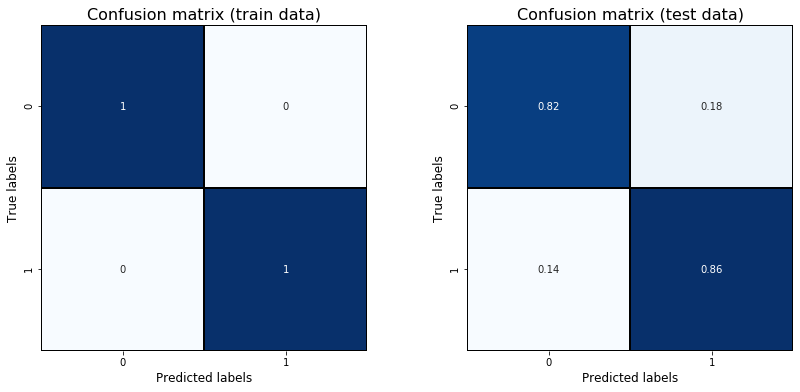

In [34]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
plot_confusion_matrix(y_train, y_train_pred, ax=axis1, 
                      title='Confusion matrix (train data)')
plot_confusion_matrix(y_test, y_test_pred, ax=axis2, 
                      title='Confusion matrix (test data)')

In [35]:
# Predict sentiment on train set
from sklearn.metrics import classification_report

print('\nClassification Report: \n', classification_report(y_test, y_test_pred))


Classification Report: 
               precision    recall  f1-score   support

           0       0.85      0.82      0.83      5055
           1       0.82      0.86      0.84      4945

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



Doesn't perform as well as the unigram BOW model, which gave an accuracy of 0.85. See the other notebook

#### 4.1.3 Make Predictions Using Vector Quantization (Clustering)

Since Word2Vec creates clusters of semantically related words, another approach is to exploit the similarity of words within a cluster.  This is known as __***vector quantization***__. I'll be using K-Means here. 

In [36]:
# Get vectors of all words fitted by the w2v_model
word_vectors = w2v_model.wv.vectors

##### Create clusters

Typically can use elbow curves and silhouette scores to identify the number of clusters, but with so many data points, it takes forever.  

In [37]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

def plot_elbow_silhouette_curves(vectors, max_cluster=10, step=1):
    X = vectors
    distortions = []
    inertias = []
    silhouettes = []
    
    # Determine K for K Means
    K = range(2, max_cluster+1, step)
    
    for k in K:
        print("Clustering with k = {}".format(k))
        kmeans_model = KMeans(n_clusters=k).fit(X)
        kmeans_model.fit(X)
        labels = kmeans_model.predict(X)
        
        distortions.append(sum(np.min(cdist(X, kmeans_model.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
        inertias.append(kmeans_model.inertia_)
        silhouettes.append(silhouette_score(X, labels, metric='euclidean'))
    
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)
    
    # plot the elbow graph using distortion
    ax1.plot(K, distortions, 'bx-')
    ax1.set_xlabel('k')
    ax1.set_ylabel('Distortion')
    ax1.set_title('Elbow graph using Distortion')
    
    # plot the elbow graph using inertia
    ax2.plot(K, inertias, 'bx-')
    ax2.set_xlabel('k')
    ax2.set_ylabel('Inertia')
    ax2.set_title('Elbow graph using Inertia')
    
    # plot silhouette scores
    ax3.plot(K, silhouettes, 'bx-')
    ax3.set_xlabel('k')
    ax3.set_ylabel('Silhouette Score')
    ax3.set_title('Silhouette Score for each cluster')

In [38]:
# plot_elbow_silhouette_curves(word_vectors, max_cluster=10000, step=500)

In [39]:
from sklearn.cluster import KMeans
import time

start = time.time()

# 5 words per cluster based on the silhouette score above
num_clusters = word_vectors.shape[0] // 5
kmeans_model = KMeans(n_clusters = num_clusters)
idx = kmeans_model.fit_predict(word_vectors)

end = time.time()

print('Time elapsed: {} seconds'.format(end-start))

Time elapsed: 1280.4886627197266 seconds


In [40]:
# Create a word / index dictionary mapping each vocab word to a cluster number
word_centroid_map = dict(zip(w2v_model.wv.index2word, idx))

for cluster in range(100, 111):
    print("\nCluster {}:".format(cluster))
    words = []
    for k, v in word_centroid_map.items():
        if v == cluster:
            words.append(k)
    
    print(words)



Cluster 100:
['isn', 'wasn', 'aren', 'weren', 'ain']

Cluster 101:
['harp', 'bethany', 'wolverine', 'aileen', 'taj', 'mira', 'seuss', 'mi', 'kellogg', 'wigand', 'har', 'nacho', 'eliot', 'zelda']

Cluster 102:
['unknown', 'isolated', 'unnamed', 'antique', 'idealized']

Cluster 103:
['controversial', 'relevant', 'topical', 'debatable', 'probable']

Cluster 104:
['sensibilities', 'sentiments']

Cluster 105:
['bleed', 'grinding', 'vent', 'diet', 'veins', 'roar', 'slices']

Cluster 106:
['accent', 'dubbed', 'accents', 'dubbing', 'dub']

Cluster 107:
['contained', 'incorporates', 'strays']

Cluster 108:
['red', 'blue', 'yellow', 'colored', 'neon', 'flashing', 'shiny']

Cluster 109:
['endearing', 'earnest']

Cluster 110:
['killed', 'trapped', 'attacked', 'kidnapped', 'possessed', 'chased', 'eaten', 'infected', 'bitten', 'dumped', 'cursed', 'hunted', 'butchered', 'slaughtered', 'abducted', 'stalked']


##### Create a Bag of Centroids
This is similar to the Bag of Words, but instead we are creating a bag of centroids, i.e., semantically related clusters

In [41]:
def create_bag_of_centroids(wordlist, word_centroid_map):
    
    # number of clusters is equal to the highest cluster index in the centroid map
    num_centroids = max(word_centroid_map.values()) + 1
    
    bag_of_centroids = np.zeros(num_centroids, dtype='float32')
    
    # Loop over the words in the review, find the cluster it belongs to 
    # and increment that cluster count by one
    for word in wordlist:
        if word in word_centroid_map:
            idx = word_centroid_map[word]
            bag_of_centroids[idx] += 1
    
    return bag_of_centroids

In [42]:
train_centroids = np.zeros((X_train.size, num_clusters), dtype='float32')

# Transform the training set reviews into bag of centroids
counter = 0
for review in clean_train_reviews:
    train_centroids[counter] = create_bag_of_centroids(review, word_centroid_map)
    counter += 1

test_centroids = np.zeros((X_test.size, num_clusters), dtype='float32')

# Transform the test set reviews into bag of centroids
counter = 0
for review in clean_test_reviews:
    test_centroids[counter] = create_bag_of_centroids(review, word_centroid_map)
    counter += 1

##### Random Forest Classifier

In [46]:
from sklearn.ensemble import RandomForestClassifier

forest = forest.fit(train_centroids, y_train)

y_train_pred = forest.predict(train_centroids)
y_test_pred = forest.predict(test_centroids)

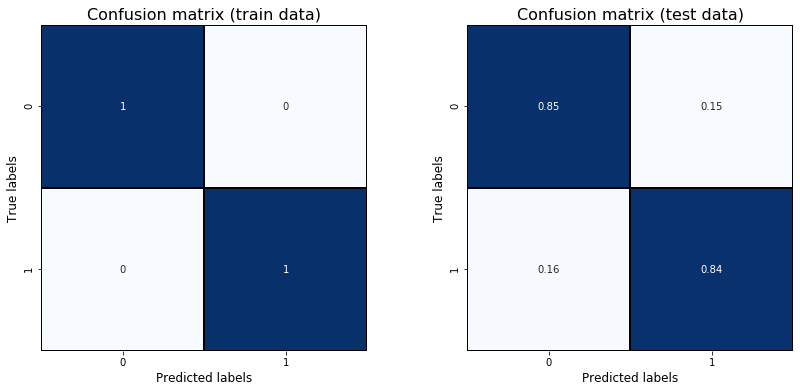

In [47]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
plot_confusion_matrix(y_train, y_train_pred, ax=axis1, 
                      title='Confusion matrix (train data)')
plot_confusion_matrix(y_test, y_test_pred, ax=axis2, 
                      title='Confusion matrix (test data)')

In [48]:
print('\nClassification Report: \n', classification_report(y_test, y_test_pred))


Classification Report: 
               precision    recall  f1-score   support

           0       0.85      0.85      0.85      5055
           1       0.84      0.84      0.84      4945

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



Pretty good, but still no better than the unigram BOW approach

### 4.2 FastText using Gensim

In [49]:
from gensim.models import fasttext
import logging 

# Configure logging so that Word2Vec creates nice output messages
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)

# Set parameter values
embed_size = 300 # Word vector dimensionality
window_context = 10 # Context window size
num_workers = 4 # Number of threads to run in parallel
min_word_count = 40 # Minimum word count
downsampling = 1e-3 # Downsample setting for frequent words

print("Training model...")
ft_model = fasttext.FastText(sentences, workers=num_workers, \
                              size=embed_size, window=window_context, 
                              min_count = min_word_count, sample=downsampling)

# Calling init_sims makes the model much more memory efficient if the model 
# is not expected to be trained any further
ft_model.init_sims(replace=True)

# save the model for future use
model_name = "ft_model_300features"
ft_model.save(model_name)

2020-01-27 15:25:11,671 : INFO : resetting layer weights


Training model...


2020-01-27 15:25:40,059 : INFO : collecting all words and their counts
2020-01-27 15:25:40,194 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-01-27 15:25:40,373 : INFO : PROGRESS: at sentence #10000, processed 226181 words, keeping 17912 word types
2020-01-27 15:25:40,470 : INFO : PROGRESS: at sentence #20000, processed 452687 words, keeping 25144 word types
2020-01-27 15:25:40,561 : INFO : PROGRESS: at sentence #30000, processed 671561 words, keeping 30272 word types
2020-01-27 15:25:40,665 : INFO : PROGRESS: at sentence #40000, processed 897947 words, keeping 34632 word types
2020-01-27 15:25:40,767 : INFO : PROGRESS: at sentence #50000, processed 1117306 words, keeping 38078 word types
2020-01-27 15:25:40,870 : INFO : PROGRESS: at sentence #60000, processed 1338925 words, keeping 41078 word types
2020-01-27 15:25:40,979 : INFO : PROGRESS: at sentence #70000, processed 1561479 words, keeping 43680 word types
2020-01-27 15:25:41,096 : INFO : PROGRESS: 

2020-01-27 15:25:47,819 : INFO : PROGRESS: at sentence #720000, processed 16095022 words, keeping 119698 word types
2020-01-27 15:25:47,919 : INFO : PROGRESS: at sentence #730000, processed 16315885 words, keeping 120387 word types
2020-01-27 15:25:48,007 : INFO : PROGRESS: at sentence #740000, processed 16538959 words, keeping 121074 word types
2020-01-27 15:25:48,096 : INFO : PROGRESS: at sentence #750000, processed 16761927 words, keeping 121794 word types
2020-01-27 15:25:48,175 : INFO : PROGRESS: at sentence #760000, processed 16981540 words, keeping 122449 word types
2020-01-27 15:25:48,264 : INFO : PROGRESS: at sentence #770000, processed 17201206 words, keeping 123122 word types
2020-01-27 15:25:48,366 : INFO : PROGRESS: at sentence #780000, processed 17429296 words, keeping 123847 word types
2020-01-27 15:25:48,471 : INFO : PROGRESS: at sentence #790000, processed 17657555 words, keeping 124556 word types
2020-01-27 15:25:48,553 : INFO : PROGRESS: at sentence #800000, processe

2020-01-27 15:27:00,811 : INFO : EPOCH 1 - PROGRESS: at 86.19% examples, 191631 words/s, in_qsize 8, out_qsize 0
2020-01-27 15:27:01,824 : INFO : EPOCH 1 - PROGRESS: at 87.68% examples, 191623 words/s, in_qsize 7, out_qsize 0
2020-01-27 15:27:02,849 : INFO : EPOCH 1 - PROGRESS: at 89.07% examples, 191335 words/s, in_qsize 8, out_qsize 0
2020-01-27 15:27:03,924 : INFO : EPOCH 1 - PROGRESS: at 90.62% examples, 191253 words/s, in_qsize 7, out_qsize 0
2020-01-27 15:27:04,962 : INFO : EPOCH 1 - PROGRESS: at 92.17% examples, 191296 words/s, in_qsize 8, out_qsize 0
2020-01-27 15:27:05,985 : INFO : EPOCH 1 - PROGRESS: at 93.75% examples, 191370 words/s, in_qsize 7, out_qsize 0
2020-01-27 15:27:06,991 : INFO : EPOCH 1 - PROGRESS: at 95.29% examples, 191390 words/s, in_qsize 8, out_qsize 0
2020-01-27 15:27:08,028 : INFO : EPOCH 1 - PROGRESS: at 96.68% examples, 191092 words/s, in_qsize 7, out_qsize 0
2020-01-27 15:27:09,049 : INFO : EPOCH 1 - PROGRESS: at 98.03% examples, 190856 words/s, in_qsiz

2020-01-27 15:28:12,087 : INFO : EPOCH 2 - PROGRESS: at 87.19% examples, 181682 words/s, in_qsize 7, out_qsize 1
2020-01-27 15:28:13,102 : INFO : EPOCH 2 - PROGRESS: at 88.56% examples, 181602 words/s, in_qsize 7, out_qsize 0
2020-01-27 15:28:14,116 : INFO : EPOCH 2 - PROGRESS: at 89.95% examples, 181527 words/s, in_qsize 7, out_qsize 0
2020-01-27 15:28:15,139 : INFO : EPOCH 2 - PROGRESS: at 90.79% examples, 180320 words/s, in_qsize 8, out_qsize 0
2020-01-27 15:28:16,150 : INFO : EPOCH 2 - PROGRESS: at 91.83% examples, 179622 words/s, in_qsize 7, out_qsize 0
2020-01-27 15:28:17,171 : INFO : EPOCH 2 - PROGRESS: at 93.01% examples, 179128 words/s, in_qsize 8, out_qsize 0
2020-01-27 15:28:18,200 : INFO : EPOCH 2 - PROGRESS: at 94.27% examples, 178738 words/s, in_qsize 8, out_qsize 0
2020-01-27 15:28:19,233 : INFO : EPOCH 2 - PROGRESS: at 95.70% examples, 178663 words/s, in_qsize 8, out_qsize 0
2020-01-27 15:28:20,257 : INFO : EPOCH 2 - PROGRESS: at 97.11% examples, 178710 words/s, in_qsiz

2020-01-27 15:29:23,313 : INFO : EPOCH 3 - PROGRESS: at 83.96% examples, 177258 words/s, in_qsize 7, out_qsize 0
2020-01-27 15:29:24,314 : INFO : EPOCH 3 - PROGRESS: at 85.40% examples, 177405 words/s, in_qsize 8, out_qsize 0
2020-01-27 15:29:25,337 : INFO : EPOCH 3 - PROGRESS: at 86.85% examples, 177479 words/s, in_qsize 8, out_qsize 0
2020-01-27 15:29:26,352 : INFO : EPOCH 3 - PROGRESS: at 88.32% examples, 177689 words/s, in_qsize 7, out_qsize 0
2020-01-27 15:29:27,420 : INFO : EPOCH 3 - PROGRESS: at 89.71% examples, 177529 words/s, in_qsize 7, out_qsize 0
2020-01-27 15:29:28,441 : INFO : EPOCH 3 - PROGRESS: at 91.17% examples, 177605 words/s, in_qsize 7, out_qsize 0
2020-01-27 15:29:29,453 : INFO : EPOCH 3 - PROGRESS: at 92.63% examples, 177700 words/s, in_qsize 7, out_qsize 0
2020-01-27 15:29:30,465 : INFO : EPOCH 3 - PROGRESS: at 94.10% examples, 177801 words/s, in_qsize 7, out_qsize 0
2020-01-27 15:29:31,490 : INFO : EPOCH 3 - PROGRESS: at 95.58% examples, 177866 words/s, in_qsiz

2020-01-27 15:30:34,666 : INFO : EPOCH 4 - PROGRESS: at 84.73% examples, 181733 words/s, in_qsize 8, out_qsize 0
2020-01-27 15:30:35,672 : INFO : EPOCH 4 - PROGRESS: at 86.24% examples, 181910 words/s, in_qsize 8, out_qsize 0
2020-01-27 15:30:36,674 : INFO : EPOCH 4 - PROGRESS: at 87.63% examples, 181855 words/s, in_qsize 7, out_qsize 0
2020-01-27 15:30:37,697 : INFO : EPOCH 4 - PROGRESS: at 88.95% examples, 181639 words/s, in_qsize 8, out_qsize 0
2020-01-27 15:30:38,776 : INFO : EPOCH 4 - PROGRESS: at 90.51% examples, 181714 words/s, in_qsize 7, out_qsize 0
2020-01-27 15:30:39,787 : INFO : EPOCH 4 - PROGRESS: at 91.94% examples, 181758 words/s, in_qsize 7, out_qsize 1
2020-01-27 15:30:40,801 : INFO : EPOCH 4 - PROGRESS: at 93.40% examples, 181782 words/s, in_qsize 7, out_qsize 0
2020-01-27 15:30:41,819 : INFO : EPOCH 4 - PROGRESS: at 94.83% examples, 181704 words/s, in_qsize 7, out_qsize 0
2020-01-27 15:30:42,824 : INFO : EPOCH 4 - PROGRESS: at 96.24% examples, 181655 words/s, in_qsiz

2020-01-27 15:31:46,489 : INFO : EPOCH 5 - PROGRESS: at 86.13% examples, 181668 words/s, in_qsize 7, out_qsize 0
2020-01-27 15:31:47,568 : INFO : EPOCH 5 - PROGRESS: at 87.57% examples, 181513 words/s, in_qsize 8, out_qsize 0
2020-01-27 15:31:48,572 : INFO : EPOCH 5 - PROGRESS: at 89.07% examples, 181691 words/s, in_qsize 7, out_qsize 0
2020-01-27 15:31:49,592 : INFO : EPOCH 5 - PROGRESS: at 90.45% examples, 181599 words/s, in_qsize 7, out_qsize 0
2020-01-27 15:31:50,611 : INFO : EPOCH 5 - PROGRESS: at 91.89% examples, 181621 words/s, in_qsize 6, out_qsize 1
2020-01-27 15:31:51,621 : INFO : EPOCH 5 - PROGRESS: at 93.35% examples, 181665 words/s, in_qsize 8, out_qsize 0
2020-01-27 15:31:52,645 : INFO : EPOCH 5 - PROGRESS: at 94.76% examples, 181565 words/s, in_qsize 8, out_qsize 0
2020-01-27 15:31:53,676 : INFO : EPOCH 5 - PROGRESS: at 96.24% examples, 181557 words/s, in_qsize 8, out_qsize 0
2020-01-27 15:31:54,727 : INFO : EPOCH 5 - PROGRESS: at 97.70% examples, 181603 words/s, in_qsiz

In [50]:
# view similar words based on gensim's model (just for curiosity's sake)
similar_words = {search_term: [item[0] for item in ft_model.wv.most_similar([search_term], topn=5)]
                     for search_term in ['movie', 'sex', 'genre', 'scary', 'romance', 'action', 
                                         'indie', 'director', 'country', 'france', 'england', 
                                         'germany', 'man', 'woman', 'kitchen', 'city', 'berlin', 'paris']}
similar_words

{'movie': ['film', 'moviegoer', 'moviegoers', 'movies', 'flick'],
 'sex': ['sexual', 'sexism', 'sexes', 'sexually', 'sexuality'],
 'genre': ['subgenre', 'genres', 'thrillers', 'category', 'horror'],
 'scary': ['scarce', 'scar', 'creepy', 'gory', 'scaring'],
 'romance': ['romanticism', 'romantic', 'romances', 'romano', 'roman'],
 'action': ['actioner', 'fraction', 'actions', 'satisfaction', 'extinction'],
 'indie': ['independent', 'indigo', 'indian', 'indies', 'indy'],
 'director': ['directorial', 'directors', 'direct', 'filmmaker', 'directs'],
 'country': ['countryside', 'countries', 'county', 'countess', 'communion'],
 'france': ['trance', 'francis', 'francisco', 'entrance', 'francois'],
 'england': ['ireland', 'poland', 'inland', 'scotland', 'finland'],
 'germany': ['germans', 'german', 'europe', 'europa', 'european'],
 'man': ['boman', 'manu', 'gunman', 'madman', 'caveman'],
 'woman': ['womanizer', 'boman', 'womanizing', 'man', 'lady'],
 'kitchen': ['chen', 'pitcher', 'bedroom', 'ba

On first look, it seems that FastText performs better than the vanilla Word2Vec. 

#### Predictions using Vector Averaging

##### Get Averages

In [51]:
# get review-level embeddings for the training set
clean_train_reviews = [review_to_wordlist(review, remove_stopwords=True) for review in X_train]
training_data_vectors = averaged_review_vectorizer(reviews=clean_train_reviews,
                                                   model = ft_model, 
                                                   num_features = embed_size)

# get review-level embeddings for the test set
clean_test_reviews = [review_to_wordlist(review, remove_stopwords=True) for review in X_test]
test_data_vectors = averaged_review_vectorizer(reviews=clean_test_reviews, 
                                               model = ft_model, 
                                               num_features = embed_size)

Review 0 of 15000


C:\Users\aksin\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


Review 1000 of 15000
Review 2000 of 15000
Review 3000 of 15000
Review 4000 of 15000
Review 5000 of 15000
Review 6000 of 15000
Review 7000 of 15000
Review 8000 of 15000
Review 9000 of 15000
Review 10000 of 15000
Review 11000 of 15000
Review 12000 of 15000
Review 13000 of 15000
Review 14000 of 15000
Review 0 of 10000
Review 1000 of 10000
Review 2000 of 10000
Review 3000 of 10000
Review 4000 of 10000
Review 5000 of 10000
Review 6000 of 10000
Review 7000 of 10000
Review 8000 of 10000
Review 9000 of 10000


##### Random Forest Classifier

In [52]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=100)
forest = forest.fit(training_data_vectors, y_train)

# Predict sentiment on train and test sets
y_train_pred = forest.predict(training_data_vectors)
y_test_pred = forest.predict(test_data_vectors)

##### Evaluate the Model

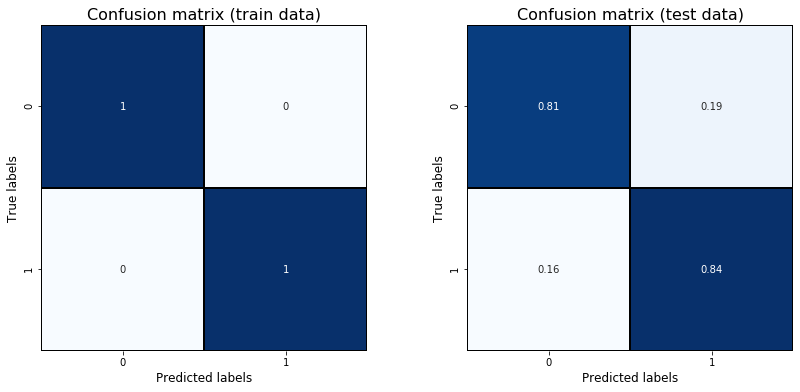

In [53]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
plot_confusion_matrix(y_train, y_train_pred, ax=axis1, 
                      title='Confusion matrix (train data)')
plot_confusion_matrix(y_test, y_test_pred, ax=axis2, 
                      title='Confusion matrix (test data)')

In [54]:
print('\nClassification Report: \n', classification_report(y_test, y_test_pred))


Classification Report: 
               precision    recall  f1-score   support

           0       0.84      0.81      0.82      5055
           1       0.81      0.84      0.83      4945

    accuracy                           0.82     10000
   macro avg       0.83      0.83      0.82     10000
weighted avg       0.83      0.82      0.82     10000



Simple BOW still undefeated. I do not expect the Vector Quantization to perform that much better given these results and am going to forego that since it's resource expensive and takes way too long

### GloVe (Global Vectors) Model

This is an unsupervised learning model, which can be used to obtain dense word vectors similar to Word2Vec. However, in this model, training is performed on aggregated global word-word co-occurrence matrix. 

Frequency-based methods like Latent Semantic Analysis (LSA) efficiently leverage statistical information but do relatively poorly on word analogy tasks like skip-gram, whereas skip-gram models poorly use the statistics of corpus on a global level. 

GloVe models aims to remedy these issues, by fkrst creating a word-context co-occurence matrix consisting on (word, context) pairs such that each elmeent in this matrix represents how often a word occurs with the context, e.g., a sequence of words. It then applies matrix factorization (as in SVD) to approximate this matrix. 

In [55]:
import spacy
import en_core_web_lg

nlp = en_core_web_lg.load()
total_vectors = len(nlp.vocab.vectors)
print('Total word vectors: ', total_vectors)

Total word vectors:  684831


In [60]:
from bs4 import BeautifulSoup
import nltk
import re
import numpy as np

wpt = nltk.WordPunctTokenizer()

# convert from list to set b/c in Python searching a set is much faster than searching a list
# Not shown here, but the difference in speed for this data set is nearly 4-fold, i.e., 
# searching the list takes abou 4x longer than searching a set. 
stop_words = set(nltk.corpus.stopwords.words('english'))

def clean_text(text):
    # strip html tags
    text = BeautifulSoup(text, "html.parser").get_text()
    
    # lower case, remove special characters, and strip leading and trailing whitespaces
    text = re.sub(r'[^a-zA-Z\s]', ' ', text, re.I|re.A)
    text = text.lower()
    text = text.strip()
    
    # tokenize
    tokens = wpt.tokenize(text)
    
    # filter out stopwords
    filtered_tokens = [word for word in tokens if word not in stop_words]
    
    # Join text back
    text = ' '.join(filtered_tokens)
    return text

clean_corpus = np.vectorize(clean_text)

In [61]:
# Use both the labeled and unlabeled training data
clean_train_reviews = clean_corpus(X_train)
clean_unlabeled_reviews = clean_corpus(unlabeled_train['review'])
clean_reviews = np.concatenate([clean_train_reviews, clean_unlabeled_reviews])

unique_words = set([word for sublist in [review.split() for review in clean_reviews] for word in sublist])

In [62]:
# get glove word embeddings
word_glove_vectors = np.array([nlp(word).vector for word in unique_words])

In [63]:
# get review-level word embeddings
# Nice thing about spacy GloVe implementation is that we don't have to 
# write a function to average embeddings. Can be done using spacy
training_glove_vectors = np.array([nlp(str(review)).vector for review in clean_train_reviews])

In [64]:
# Clean test reviews and get review-level word embeddings
clean_test_reviews = clean_corpus(X_test)
test_glove_vectors = np.array([nlp(str(review)).vector for review in clean_test_reviews])

##### Random Forest Classifier

In [65]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=100)
forest = forest.fit(training_glove_vectors, y_train)

##### Evaluate the Model

In [66]:
# Predict sentiment on train and test sets
y_train_pred = forest.predict(training_glove_vectors)
y_test_pred = forest.predict(test_glove_vectors)

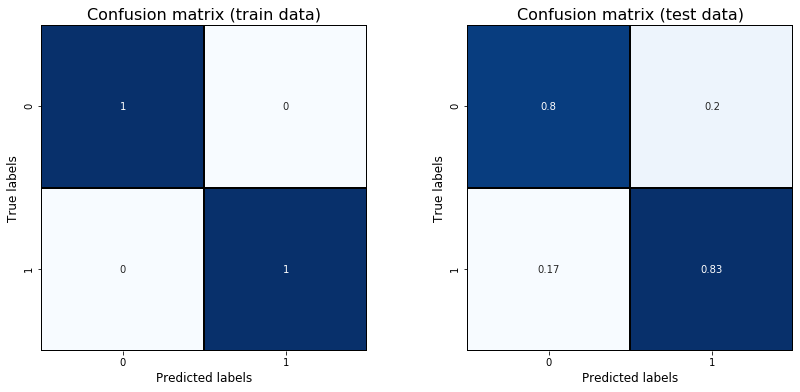

In [67]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
plot_confusion_matrix(y_train, y_train_pred, ax=axis1, 
                      title='Confusion matrix (train data)')
plot_confusion_matrix(y_test, y_test_pred, ax=axis2, 
                      title='Confusion matrix (test data)')

In [68]:
print('\nClassification Report: \n', classification_report(y_test, y_test_pred))


Classification Report: 
               precision    recall  f1-score   support

           0       0.83      0.80      0.82      5055
           1       0.80      0.83      0.82      4945

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000



Amazingly, BOW is still the best model